In [ ]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 43.7 MB/s eta 0:00:00


In [ ]:
from jiwer import *
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import re

In [ ]:
df = pd.read_csv("DementiaSnips.csv")
df = df.rename(columns={'transcript': 'ground_truth'})
df['model_transcription'] = df['ground_truth']

In [ ]:
df

,file,ground_truth,Age,Gender,model_transcription
0,co007-03snip1.wav,well the girl is telling the boy to get the co...,75.0,Female,well the girl is telling the boy to get the co...
1,co007-03snip2.wav,and basically it's kind of &-uh a distressing ...,75.0,Female,and basically it's kind of &-uh a distressing ...
2,sen010-2-3.1snip1.wav,the child <fell and hadta go> [/] fell and had...,68.0,Male,the child <fell and hadta go> [/] fell and had...
3,sen010-2-3.1snip2.wav,I sat (.) in the doctor's chair .,68.0,Male,I sat (.) in the doctor's chair .
4,sen010-2-3.1snip3.wav,I opened the drawer of the (.) bureau (.) to g...,68.0,Male,I opened the drawer of the (.) bureau (.) to g...
...,...,...,...,...,...
107,(c)co006-2.1snip5.wav,NaN,NaN,NaN,NaN
108,(c)co006-2.1snip4.wav,NaN,NaN,NaN,NaN
109,(c)co006-2.1snip3.wav,NaN,NaN,NaN,NaN
110,(c)co006-2.1snip2.wav,NaN,NaN,NaN,NaN


In [ ]:
def normalize_transcription(text):
  if text is None:
    return ""
  text = str(text)

  # unify whitespace
  text = text.replace("\n", " ")

  # prefer speaker correction before removing brackets: "word [: replacement]" -> "replacement"
  text = re.sub(r'\b\w+\s*\[:\s*([^\]]+)\]', r'\1', text)

  # remove remaining bracket annotations: [/], [//], [* ...], [: ...], etc.
  text = re.sub(r'\[[^\]]+\]', ' ', text)

  # remove angle-bracket fragments/retraces: <...>
  text = re.sub(r'<[^>]+>', ' ', text)

  # micro-pause markers: (.), (..), (...)
  text = re.sub(r'\(\.*\)', ' ', text)

  # normalize "(g)" inflection: askin(g) -> asking, dryin(g) -> drying
  text = re.sub(r'([A-Za-z]+)\(g\)', r'\1g', text)

  # remove chat codes: &=..., &-..., &+...
  text = re.sub(r'&[-=+][^\s.]+', ' ', text)

  # drop "+..." fragments and lone +tokens
  text = re.sub(r'\+\S*', ' ', text)

  # colloquial fixes
  text = re.sub(r'\bhafta\b', 'have to', text, flags=re.IGNORECASE)
  text = re.sub(r'\bhadta\b', 'had to', text, flags=re.IGNORECASE)
  text = re.sub(r'\bwanna\b', 'want to', text, flags=re.IGNORECASE)

  # collapse whitespace
  text = re.sub(r'\s+', ' ', text).strip()

  return text


In [ ]:
transformation = Compose([
    normalize_transcription,
    RemovePunctuation(),
    ToLowerCase(),
    RemoveMultipleSpaces(),
    ExpandCommonEnglishContractions(),
    Strip()
])

In [ ]:
sample_text = """well the girl is telling the boy to get the cookies down but don't tell your mother. and the boy is also falling over off the stool  and the mother is letting the water run out of the sink . and she's dryin(g) dishes .
and basically it's kind of &-uh a distressing scene .
the child <fell and hadta go> [/] fell and hadta go to the hospital ."""

cleaned = transformation(sample_text)
print("Original:")
print(sample_text)
print("\nCleaned:")
print(cleaned)

Original:
well the girl is telling the boy to get the cookies down but don't tell your mother. and the boy is also falling over off the stool  and the mother is letting the water run out of the sink . and she's dryin(g) dishes .
and basically it's kind of &-uh a distressing scene .
the child <fell and hadta go> [/] fell and hadta go to the hospital .

Cleaned:
well the girl is telling the boy to get the cookies down but dont tell your mother and the boy is also falling over off the stool and the mother is letting the water run out of the sink and shes drying dishes and basically its kind of a distressing scene the child fell and had to go to the hospital


In [ ]:
df = df.copy()
df["gt_clean"]  = df["ground_truth"].fillna("").astype(str).map(transformation)
df["mod_clean"] = df["model_transcription"].fillna("").astype(str).map(transformation)

In [ ]:
df

,file,ground_truth,Age,Gender,model_transcription,gt_clean,mod_clean
0,co007-03snip1.wav,well the girl is telling the boy to get the co...,75.0,Female,well the girl is telling the boy to get the co...,well the girl is telling the boy to get the co...,well the girl is telling the boy to get the co...
1,co007-03snip2.wav,and basically it's kind of &-uh a distressing ...,75.0,Female,and basically it's kind of &-uh a distressing ...,and basically its kind of a distressing scene,and basically its kind of a distressing scene
2,sen010-2-3.1snip1.wav,the child <fell and hadta go> [/] fell and had...,68.0,Male,the child <fell and hadta go> [/] fell and had...,the child fell and had to go to the hospital,the child fell and had to go to the hospital
3,sen010-2-3.1snip2.wav,I sat (.) in the doctor's chair .,68.0,Male,I sat (.) in the doctor's chair .,i sat in the doctors chair,i sat in the doctors chair
4,sen010-2-3.1snip3.wav,I opened the drawer of the (.) bureau (.) to g...,68.0,Male,I opened the drawer of the (.) bureau (.) to g...,i opened the drawer of the bureau to get a par...,i opened the drawer of the bureau to get a par...
...,...,...,...,...,...,...,...
107,(c)co006-2.1snip5.wav,NaN,NaN,NaN,NaN,,
108,(c)co006-2.1snip4.wav,NaN,NaN,NaN,NaN,,
109,(c)co006-2.1snip3.wav,NaN,NaN,NaN,NaN,,
110,(c)co006-2.1snip2.wav,NaN,NaN,NaN,NaN,,


In [ ]:
def process_dataframe(
    df: pd.DataFrame,
    ref_col: str = "ground_truth",
    hyp_col: str = "model_transcription",
    normalizer=transformation,
    return_corpus: bool = True,
):
    """
    Cleans df[ref_col] and df[hyp_col] with `normalizer`, then computes:
      Word-level: wer, mer, wil, wip, hits, substitutions, deletions, insertions
      Char-level: cer, hits, substitutions, deletions, insertions
    Returns:
      metrics_df (original + *_clean + all metrics), and a corpus_stats dict.
    """
    out = df.copy()

    # normalize text
    out["gt_clean"]  = out[ref_col].fillna("").astype(str).map(normalizer)
    out["hyp_clean"] = out[hyp_col].fillna("").astype(str).map(normalizer)

    # per-row metrics
    records = []
    for g, h in zip(out["gt_clean"], out["hyp_clean"]):
        w = process_words(g, h)         # word-level stats object
        c = process_characters(g, h)    # char-level stats object
        records.append({
            # word-level
            "wer": w.wer,
            "mer": w.mer,
            "wil": w.wil,
            "wip": w.wip,
            "w_hits": w.hits,
            "w_substitutions": w.substitutions,
            "w_deletions": w.deletions,
            "w_insertions": w.insertions,
            # char-level
            "cer": c.cer,
            "c_hits": c.hits,
            "c_substitutions": c.substitutions,
            "c_deletions": c.deletions,
            "c_insertions": c.insertions,
        })

    metrics = pd.DataFrame.from_records(records, index=out.index)
    out = pd.concat([out, metrics], axis=1)

    if not return_corpus:
        return out

    # corpus-level aggregates
    w_corpus = process_words(" ".join(out["gt_clean"]), " ".join(out["hyp_clean"]))
    c_corpus = process_characters("".join(out["gt_clean"]), "".join(out["hyp_clean"]))
    corpus_stats = {
        # word-level corpus
        "corpus_wer": w_corpus.wer,
        "corpus_mer": w_corpus.mer,
        "corpus_wil": w_corpus.wil,
        "corpus_wip": w_corpus.wip,
        "corpus_w_hits": w_corpus.hits,
        "corpus_w_substitutions": w_corpus.substitutions,
        "corpus_w_deletions": w_corpus.deletions,
        "corpus_w_insertions": w_corpus.insertions,
        # char-level corpus
        "corpus_cer": c_corpus.cer,
        "corpus_c_hits": c_corpus.hits,
        "corpus_c_substitutions": c_corpus.substitutions,
        "corpus_c_deletions": c_corpus.deletions,
        "corpus_c_insertions": c_corpus.insertions,
        #  per-row means
        "row_mean_wer": out["wer"].mean(),
        "row_mean_cer": out["cer"].mean(),
    }

    return out, corpus_stats


In [ ]:
processed_df, corpus = process_dataframe(df)
processed_df.head()         # has gt_clean, hyp_clean, and all metrics
print(corpus["corpus_wer"]) # overall WER
print(corpus["corpus_cer"]) # overall CER


0.0
0.0


In [ ]:
processed_df

,file,ground_truth,Age,Gender,model_transcription,gt_clean,mod_clean,hyp_clean,wer,mer,...,wip,w_hits,w_substitutions,w_deletions,w_insertions,cer,c_hits,c_substitutions,c_deletions,c_insertions
0,co007-03snip1.wav,well the girl is telling the boy to get the co...,75.0,Female,well the girl is telling the boy to get the co...,well the girl is telling the boy to get the co...,well the girl is telling the boy to get the co...,well the girl is telling the boy to get the co...,0.0,0.0,...,1.0,43,0,0,0,0.0,208,0,0,0
1,co007-03snip2.wav,and basically it's kind of &-uh a distressing ...,75.0,Female,and basically it's kind of &-uh a distressing ...,and basically its kind of a distressing scene,and basically its kind of a distressing scene,and basically its kind of a distressing scene,0.0,0.0,...,1.0,8,0,0,0,0.0,45,0,0,0
2,sen010-2-3.1snip1.wav,the child <fell and hadta go> [/] fell and had...,68.0,Male,the child <fell and hadta go> [/] fell and had...,the child fell and had to go to the hospital,the child fell and had to go to the hospital,the child fell and had to go to the hospital,0.0,0.0,...,1.0,10,0,0,0,0.0,44,0,0,0
3,sen010-2-3.1snip2.wav,I sat (.) in the doctor's chair .,68.0,Male,I sat (.) in the doctor's chair .,i sat in the doctors chair,i sat in the doctors chair,i sat in the doctors chair,0.0,0.0,...,1.0,6,0,0,0,0.0,26,0,0,0
4,sen010-2-3.1snip3.wav,I opened the drawer of the (.) bureau (.) to g...,68.0,Male,I opened the drawer of the (.) bureau (.) to g...,i opened the drawer of the bureau to get a par...,i opened the drawer of the bureau to get a par...,i opened the drawer of the bureau to get a par...,0.0,0.0,...,1.0,13,0,0,0,0.0,63,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,(c)co006-2.1snip5.wav,NaN,NaN,NaN,NaN,,,,0.0,0.0,...,1.0,0,0,0,0,0.0,0,0,0,0
108,(c)co006-2.1snip4.wav,NaN,NaN,NaN,NaN,,,,0.0,0.0,...,1.0,0,0,0,0,0.0,0,0,0,0
109,(c)co006-2.1snip3.wav,NaN,NaN,NaN,NaN,,,,0.0,0.0,...,1.0,0,0,0,0,0.0,0,0,0,0
110,(c)co006-2.1snip2.wav,NaN,NaN,NaN,NaN,,,,0.0,0.0,...,1.0,0,0,0,0,0.0,0,0,0,0


In [ ]:
def visualize_asr_metrics(processed_df, save_dir="/mnt/data/asr_plots"):

    Path(save_dir).mkdir(parents=True, exist_ok=True)
    saved = []

    def _save_and_show(fig, fname, title=None):
        if title:
            fig.suptitle(title)
        fig.tight_layout()
        fig.savefig(os.path.join(save_dir, fname), dpi=150, bbox_inches="tight")
        plt.show()
        saved.append(os.path.join(save_dir, fname))

    # Histograms
    for col, title in [
        ("wer", "WER Distribution"),
        ("cer", "CER Distribution"),
        ("mer", "MER Distribution"),
        ("wip", "WIP (Word Information Preserved) Distribution"),
        ("wil", "WIL (Word Information Lost) Distribution"),
    ]:
        if col in processed_df.columns:
            fig = plt.figure()
            plt.hist(processed_df[col].dropna(), bins=30)
            plt.xlabel(col.upper()); plt.ylabel("Count"); plt.title(title)
            _save_and_show(fig, f"{col}_hist.png")

    # WER vs CER
    if {"wer","cer"}.issubset(processed_df.columns):
        fig = plt.figure()
        plt.scatter(processed_df["wer"], processed_df["cer"], alpha=0.6)
        plt.xlabel("WER"); plt.ylabel("CER"); plt.title("WER vs CER")
        _save_and_show(fig, "wer_vs_cer_scatter.png")

    # Word-level totals
    w_cols = ["w_hits", "w_substitutions", "w_deletions", "w_insertions"]
    if all(c in processed_df.columns for c in w_cols):
        totals = processed_df[w_cols].sum()
        fig = plt.figure()
        plt.bar(totals.index, totals.values)
        plt.title("Word-level Totals (Hits/Subs/Dels/Ins)")
        plt.xlabel("Word-level Metric"); plt.ylabel("Total Count")
        _save_and_show(fig, "word_level_totals.png")

    # Char-level totals
    c_cols = ["c_hits", "c_substitutions", "c_deletions", "c_insertions"]
    if all(c in processed_df.columns for c in c_cols):
        totals = processed_df[c_cols].sum()
        fig = plt.figure()
        plt.bar(totals.index, totals.values)
        plt.title("Character-level Totals (Hits/Subs/Dels/Ins)")
        plt.xlabel("Character-level Metric"); plt.ylabel("Total Count")
        _save_and_show(fig, "char_level_totals.png")

    # 5 Boxplots
    if "wer" in processed_df.columns:
        fig = plt.figure(); plt.boxplot(processed_df["wer"].dropna(), vert=True, labels=["WER"])
        plt.title("WER Boxplot"); _save_and_show(fig, "wer_boxplot.png")
    if "cer" in processed_df.columns:
        fig = plt.figure(); plt.boxplot(processed_df["cer"].dropna(), vert=True, labels=["CER"])
        plt.title("CER Boxplot"); _save_and_show(fig, "cer_boxplot.png")

    # Top-K error bars
    top_k = min(25, len(processed_df))
    if top_k and all(c in processed_df.columns for c in w_cols):
        df_top = processed_df.nlargest(top_k, "wer")[w_cols]
        totals_per_utt = (df_top["w_substitutions"] + df_top["w_deletions"] + df_top["w_insertions"])
        fig = plt.figure()
        plt.bar(range(len(totals_per_utt)), totals_per_utt.values)
        plt.title(f"Top {top_k} Utterances by WER — Word Errors per Utterance")
        plt.xlabel("Utterance Index (Top-K by WER)"); plt.ylabel("Word Errors (S + D + I)")
        _save_and_show(fig, "topK_word_errors_per_utterance.png")

    if top_k and all(c in processed_df.columns for c in c_cols):
        df_top = processed_df.nlargest(top_k, "cer")[c_cols]
        totals_per_utt = (df_top["c_substitutions"] + df_top["c_deletions"] + df_top["c_insertions"])
        fig = plt.figure()
        plt.bar(range(len(totals_per_utt)), totals_per_utt.values)
        plt.title(f"Top {top_k} Utterances by CER — Char Errors per Utterance")
        plt.xlabel("Utterance Index (Top-K by CER)"); plt.ylabel("Char Errors (S + D + I)")
        _save_and_show(fig, "topK_char_errors_per_utterance.png")

    return saved


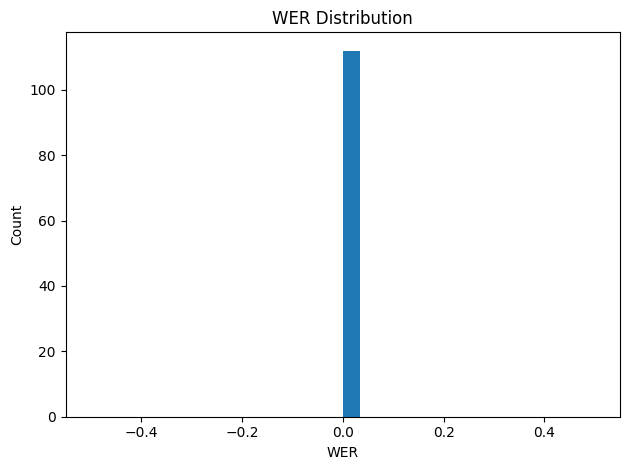

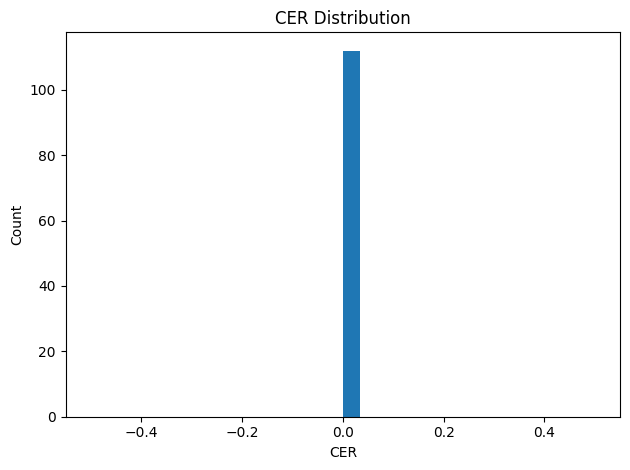

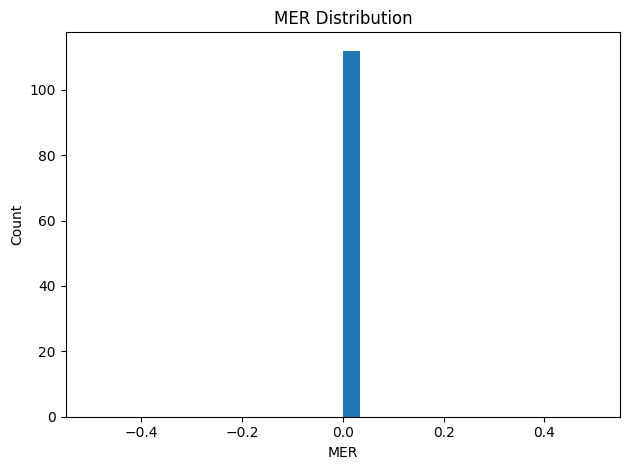

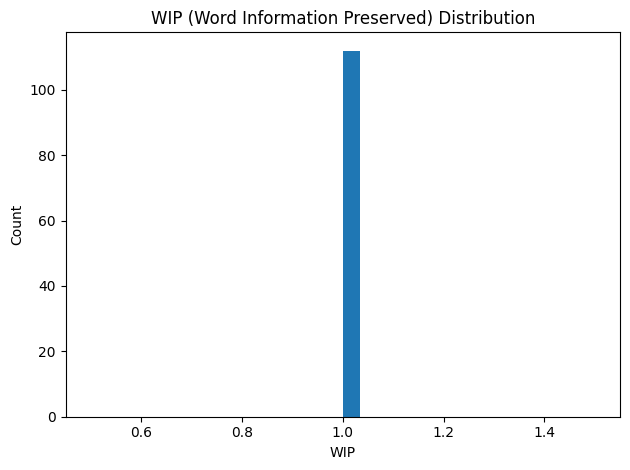

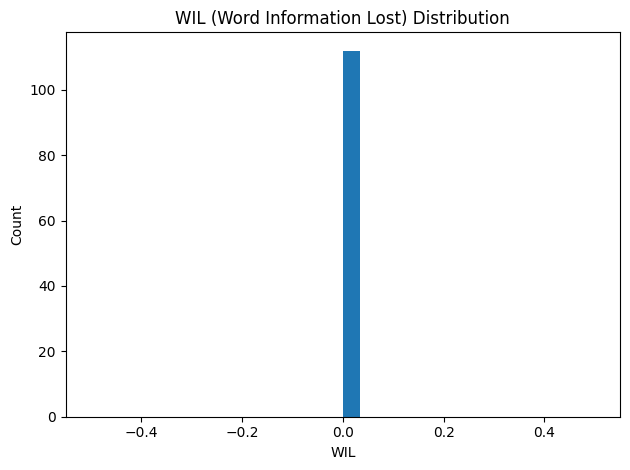

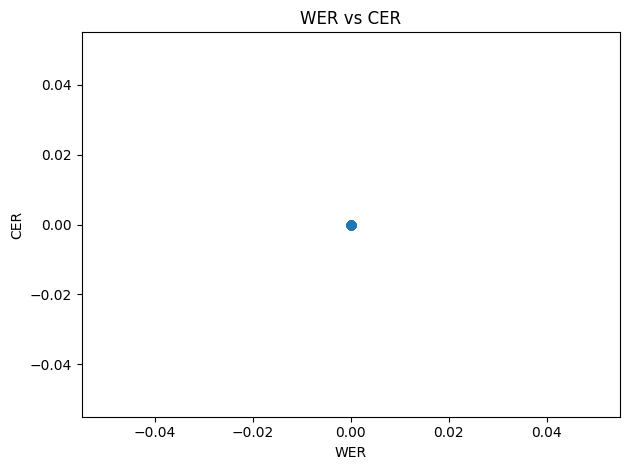

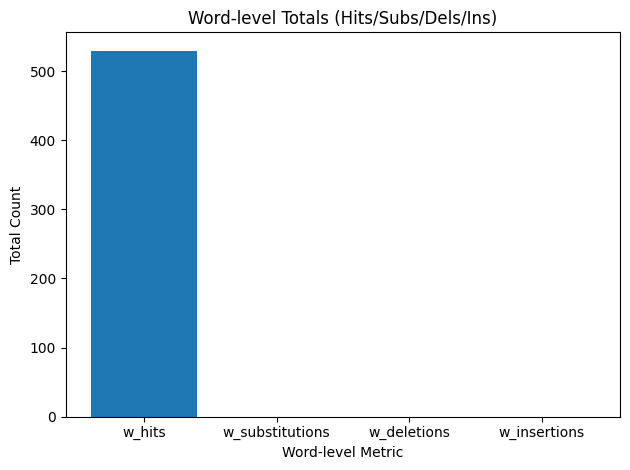

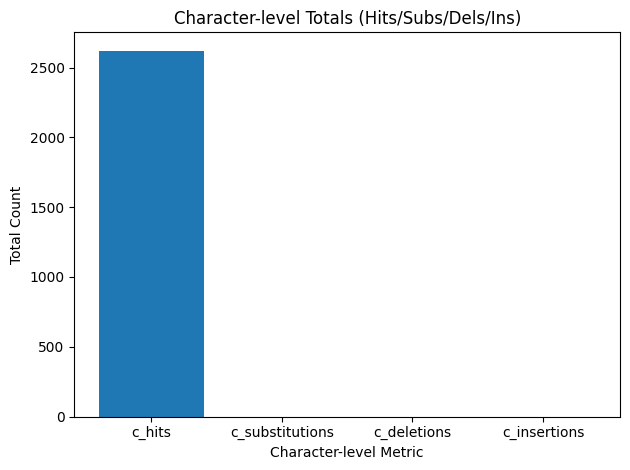

/tmp/ipython-input-2591777668.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  fig = plt.figure(); plt.boxplot(processed_df["wer"].dropna(), vert=True, labels=["WER"])


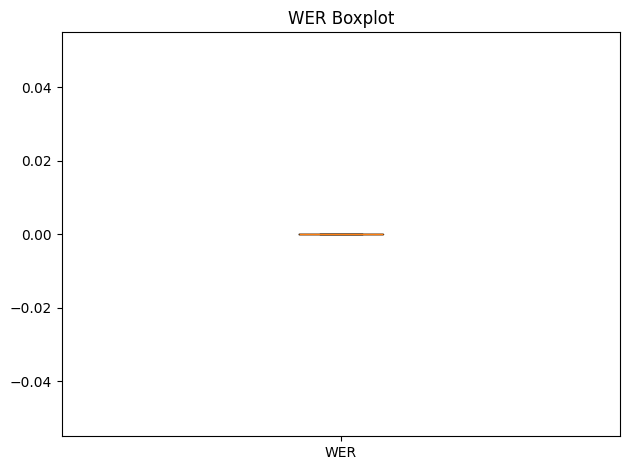

/tmp/ipython-input-2591777668.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  fig = plt.figure(); plt.boxplot(processed_df["cer"].dropna(), vert=True, labels=["CER"])


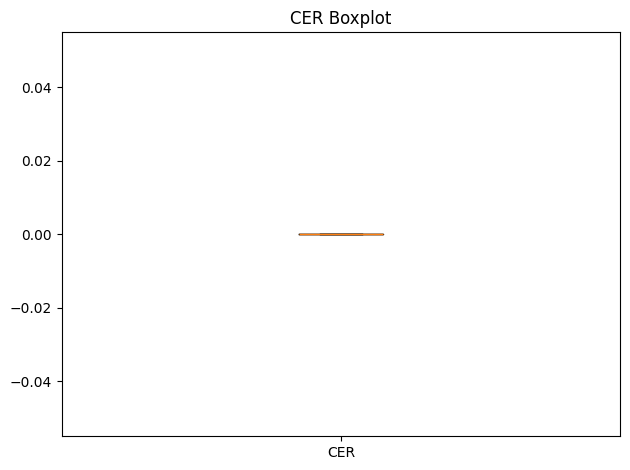

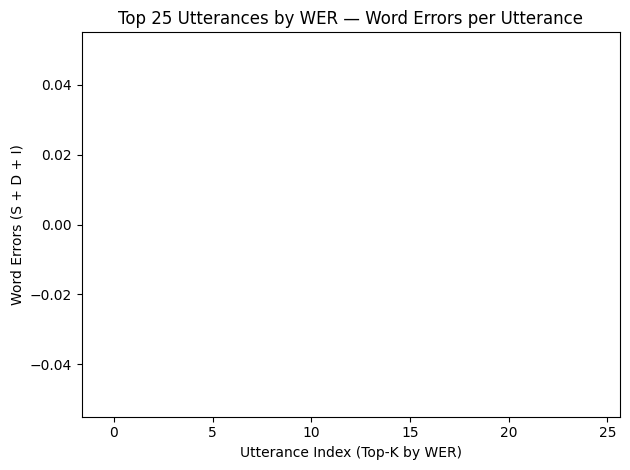

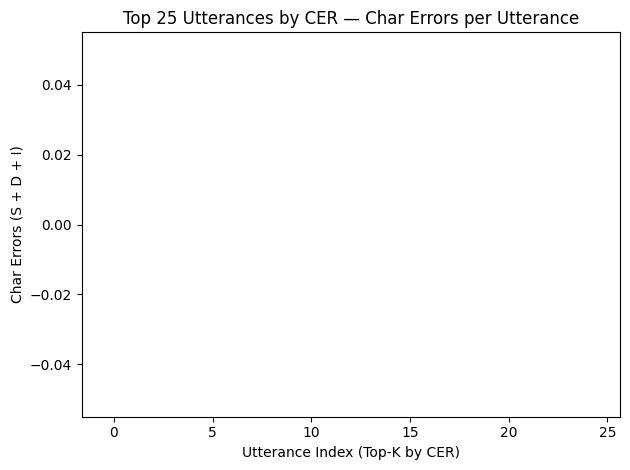

['/mnt/data/asr_plots/wer_hist.png',
 '/mnt/data/asr_plots/cer_hist.png',
 '/mnt/data/asr_plots/mer_hist.png',
 '/mnt/data/asr_plots/wip_hist.png',
 '/mnt/data/asr_plots/wil_hist.png',
 '/mnt/data/asr_plots/wer_vs_cer_scatter.png',
 '/mnt/data/asr_plots/word_level_totals.png',
 '/mnt/data/asr_plots/char_level_totals.png',
 '/mnt/data/asr_plots/wer_boxplot.png',
 '/mnt/data/asr_plots/cer_boxplot.png',
 '/mnt/data/asr_plots/topK_word_errors_per_utterance.png',
 '/mnt/data/asr_plots/topK_char_errors_per_utterance.png']

In [ ]:
visualizations = visualize_asr_metrics(processed_df)
visualizations
